# Klasyfikacja diamentów 
## Cel: znalezienie jakości cięcia (cut)


# 1.	Wczytanie niezbędnych pakietów

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn import tree


pd.options.display.float_format = "{:.2f}".format

# 2.	Przygotowanie danych do analizy

In [40]:
dane = pd.read_csv('diamonds.csv')
dane = dane.drop(columns=['Unnamed: 0'])

In [41]:
print('Obiektów: ', dane.shape[0])
print('Atrybutów: ', dane.shape[1])
print('Wartości nan: ', dane.isnull().sum().sum())
dane.head()

Obiektów:  53940
Atrybutów:  10
Wartości nan:  0


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.50,55.00,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.80,61.00,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.90,65.00,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.40,58.00,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.30,58.00,335,4.34,4.35,2.75


In [42]:
dane.describe()

,carat,depth,table,price,x,y,z
count,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00
mean,0.80,61.75,57.46,3932.80,5.73,5.73,3.54
std,0.47,1.43,2.23,3989.44,1.12,1.14,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5324.25,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


### Błędne dane
Zbiór nie posiada wartości pustych, ale posiada inne błędne dane, ponieważ wymiary diamentu nie mogą być równe 0.

In [43]:
dane.loc[(dane['x']==0) | (dane['y']==0) | (dane['z']==0)].head(4)

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.10,59.00,3142,6.55,6.48,0.00
2314,1.01,Premium,H,I1,58.10,59.00,3167,6.66,6.60,0.00
4791,1.10,Premium,G,SI2,63.00,59.00,3696,6.50,6.47,0.00
5471,1.01,Premium,F,SI2,59.20,58.00,3837,6.50,6.47,0.00


### Odstające punkty
Różnica między trzecim kwartylem a maksymalną wartością x i y sugeruje, że w zbiorze znajdują się znacznie odstające punkty, których możemy się pozbyć.

In [44]:
dane.loc[(dane['y'] > 20) | (dane['z'] > 20) | (dane['table'] > 80)]

,carat,cut,color,clarity,depth,table,price,x,y,z
24067,2.00,Premium,H,SI2,58.90,57.00,12210,8.09,58.90,8.06
24932,2.01,Fair,F,SI1,58.60,95.00,13387,8.32,8.31,4.87
48410,0.51,Very Good,E,VS1,61.80,54.70,1970,5.12,5.15,31.80
49189,0.51,Ideal,E,VS1,61.80,55.00,2075,5.15,31.80,5.12


In [45]:
l = str( len(dane.loc[(dane['x']==0) | (dane['y']==0) | (dane['z']==0)]) + len(dane.loc[(dane['y'] > 20) | (dane['z'] > 20) | (dane['table'] > 80)]))
print("Ilość odrzuconych danych: " +  l)
dane = dane[(dane[['x','y','z']] != 0 ).all(axis=1)]
dane = dane[(dane[['y','z']] < 20 ).all(axis=1)]
dane = dane[(dane[['table']] < 80 ).all(axis=1)]

Ilość odrzuconych danych: 24


### Finalna postać danych

In [46]:
dane.describe()

,carat,depth,table,price,x,y,z
count,53916.00,53916.00,53916.00,53916.00,53916.00,53916.00,53916.00
mean,0.80,61.75,57.46,3930.74,5.73,5.73,3.54
std,0.47,1.43,2.23,3987.04,1.12,1.11,0.69
min,0.20,43.00,43.00,326.00,3.73,3.68,1.07
25%,0.40,61.00,56.00,949.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5322.25,6.54,6.54,4.04
max,5.01,79.00,79.00,18823.00,10.74,10.54,6.98


# 3.	Analiza danych

## a) Dane liczbowe

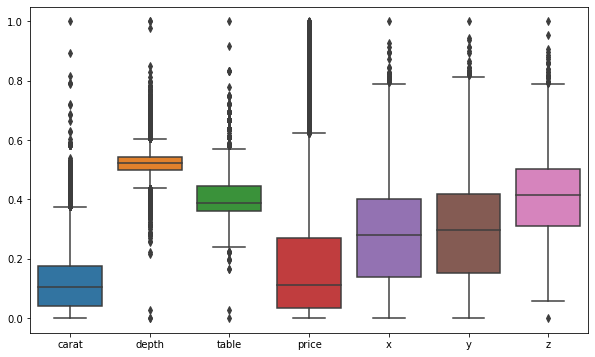

In [47]:
dane_num = dane.drop(columns=['cut','color','clarity'])
minmax = MinMaxScaler(feature_range=(0,1))
minmax_df = minmax.fit_transform(dane_num)
minmax_scaled = pd.DataFrame(minmax_df, columns=dane_num.columns)
plt.figure(figsize=(10,6))
sns.boxplot(data=minmax_scaled)





Atrybuty: **carat**,**depth** i **table** zmieniają się w malym stopniu a **price**,**x**,**y** i **z** w średnim stopniu.

### Zależność między atrybutami

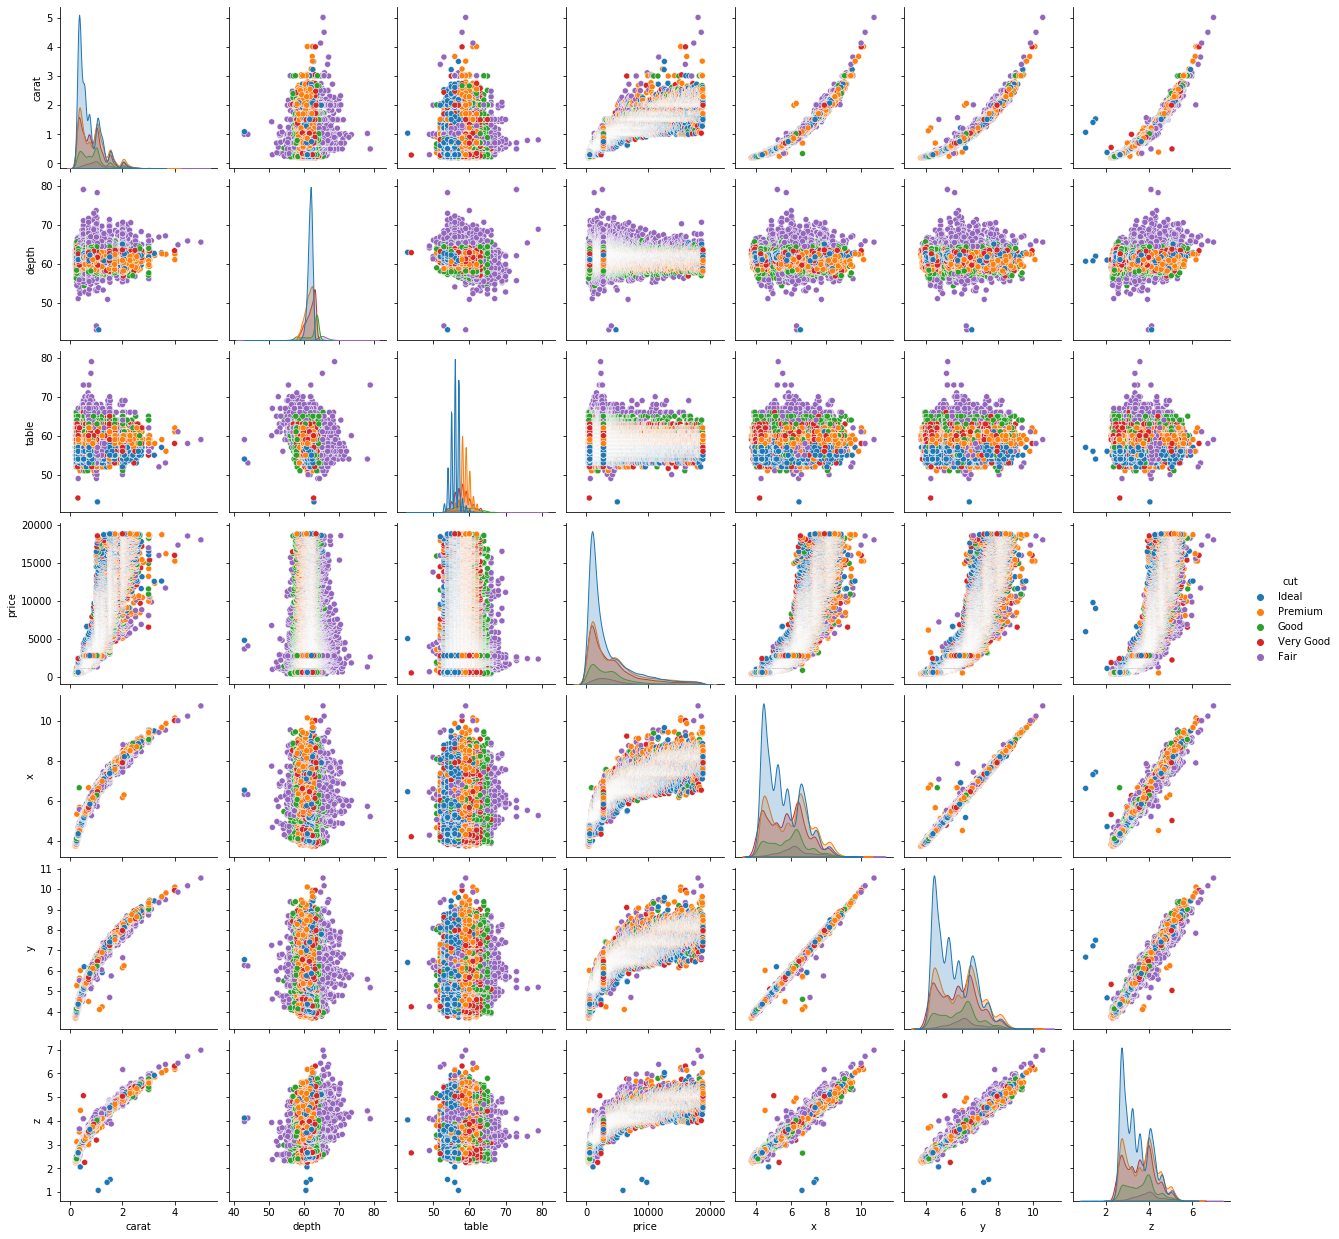

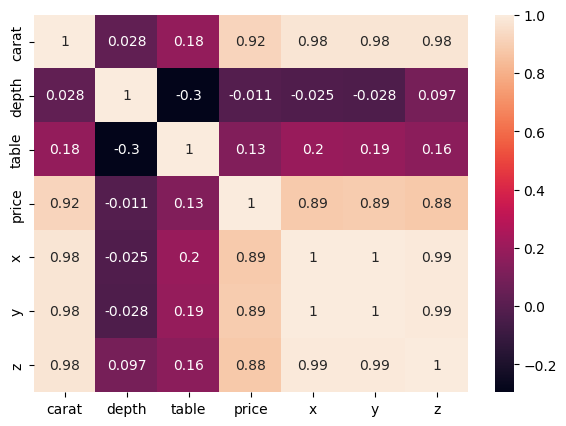

In [48]:
sns.pairplot(dane, kind="scatter", hue = 'cut')
kor = dane.corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(kor, annot = kor)

### Odrzucamy atrybuty nadmiarowe

Artybuty: **price**, **x**, **y**, **z** i **carat** są ze sobą silnie skorelowane, więc do klasyfikacji wystarczy nam jeden z nich.

In [49]:
dane = dane.drop(columns=['x','y','z','carat'])
dane.head()

,cut,color,clarity,depth,table,price
0,Ideal,E,SI2,61.50,55.00,326
1,Premium,E,SI1,59.80,61.00,326
2,Good,E,VS1,56.90,65.00,327
3,Premium,I,VS2,62.40,58.00,334
4,Good,J,SI2,63.30,58.00,335


## b) Dane kategoryczne

### Cut

Oceniając poprawność wykonania szlifu analizuje się proporcje kamienia i wykończenie szlifu (w tym błędy symetrii i polerowania). Ocenia się je w skali: bardzo dobre, dobre, średnie i słabe.
Ocenia się je w skali: **Fair, Good, Very Good, Premium, Ideal**, gdzie **Fai**r to najgorszy szlif a **Ideal** to najlepszy szlif.

Naszym celem jest klasyfikacja względem jakości szlifu, więc musimy zbadać zależności między cut a pozostałymi atrybutami i zdecydować, które atrybuty nadają się do takiej klasyfikacji.

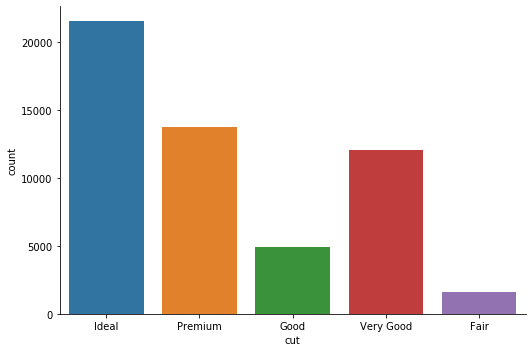

In [50]:
sns.catplot(x='cut', data=dane , kind='count' ,aspect=1.5)

Najwięcej jest diamentów z szlifem **Ideal** a diamentów z szlifem **Fair** jest bardzo mało w stosunku do ilości innych szlifów.

#### cut vs atrybuty liczbowe

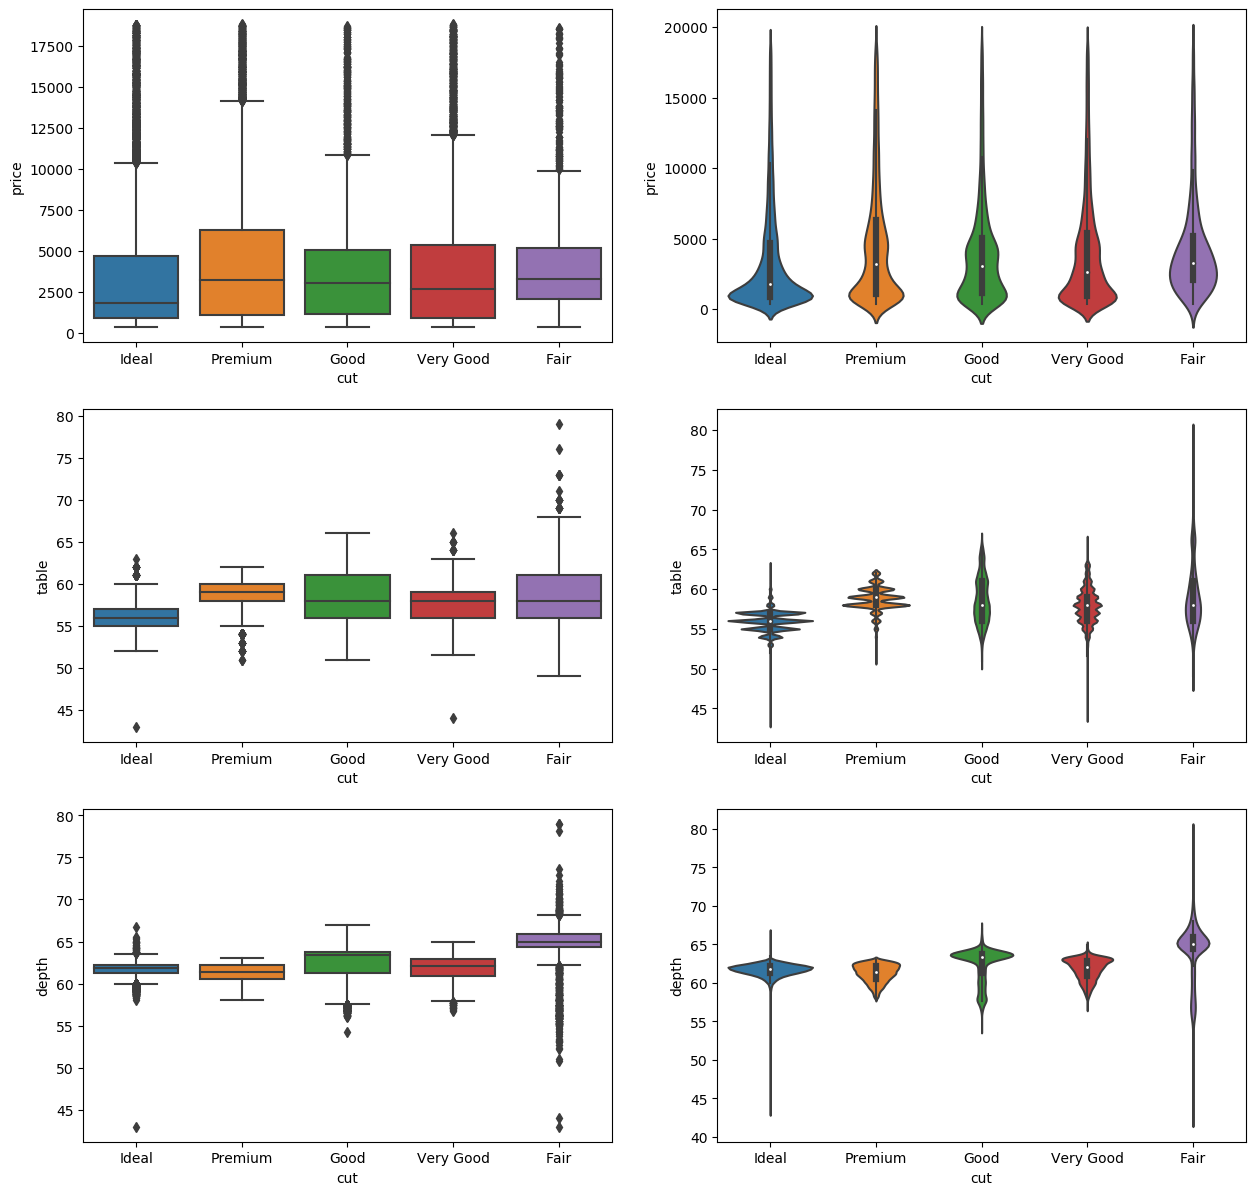

In [51]:
plt.figure(figsize=(15,15),dpi = 100)
plt.subplot(3,2,1)
sns.boxplot(x='cut', y='price', data=dane)
plt.subplot(3,2,2)
sns.violinplot(x='cut', y='price', data=dane)
plt.subplot(3,2,3)
sns.boxplot(x='cut', y='table', data=dane)
plt.subplot(3,2,4)
sns.violinplot(x='cut', y='table', data=dane)
plt.subplot(3,2,5)
sns.boxplot(x='cut', y='depth', data=dane)
plt.subplot(3,2,6)
sns.violinplot(x='cut', y='depth', data=dane)

Atrybuty przydatne do klasyfikacji to **table** i **depth**.
* table pozwoli rozpoznać  **Ideal** cut
* depth pozwoli rozpoznać **Fair** cut

#### cut vs atrybuty kategoryczne

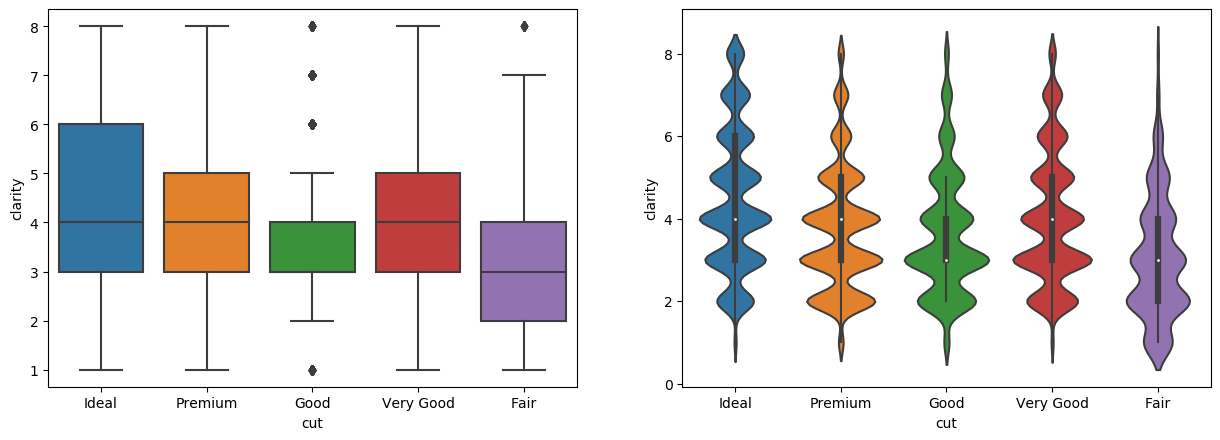

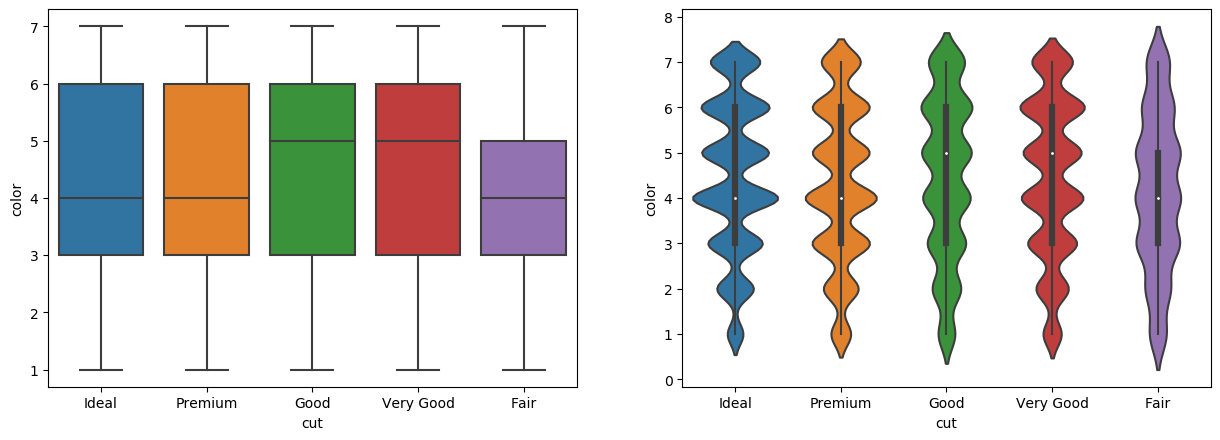

In [52]:
tmp = dane.copy()
i = 1
for s in ['I1', 'SI2','SI1','VS2','VS1','VVS2','VVS1','IF']:
    dane['clarity'] = dane['clarity'].replace([s],i)
    i= i+1
    
plt.figure(figsize=(15,5),dpi = 100)
plt.subplot(1,2,1)
sns.boxplot(x='cut', y='clarity', data=dane)
plt.subplot(1,2,2)
sns.violinplot(x='cut', y='clarity', data=dane)

i = 1
for s in ['J','I','H','G','F','E','D']:
    dane['color'] = dane['color'].replace([s],i)
    i= i+1
    
plt.figure(figsize=(15,5),dpi = 100)
plt.subplot(1,2,1)
sns.boxplot(x='cut', y='color', data=dane)
plt.subplot(1,2,2)
sns.violinplot(x='cut', y='color', data=dane)

Atrybuty kategoryczne są porządkowe, więc można im przypisać wartosci liczbowe. **Color** i **clarity** nie będą przydatne w klasyfikacji, bo osiągają zbliżone wartości dla wszystkich klas. 

### Clarity

Czystośc diamentu oceniamy na podstawie jego zaniczyszczeń zewnętrznych i wewnętrznych.
Czystości diamentów dzielimy na:
* I1(first degree inclusions) - zanieczyszczenia pierwszego stopnia
* SI(small inclusions) - małe zanieczyszczenia
* VSI(very small inclusions) - bardzo małe zanieczyszczenia
* IF(internally flawless) - bez skazy

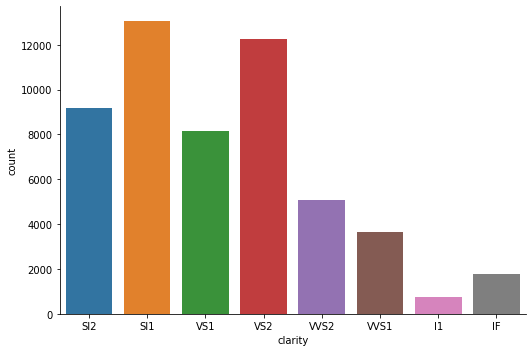

In [53]:
sns.catplot(x='clarity', data=tmp , kind='count', aspect = 1.5 )

Ilościowo dominują diamenty średniej czystości. Najmniej jest diamentów o najlepszej i najgorszej czystości: **I1** i **IF**.

#### clarity vs price

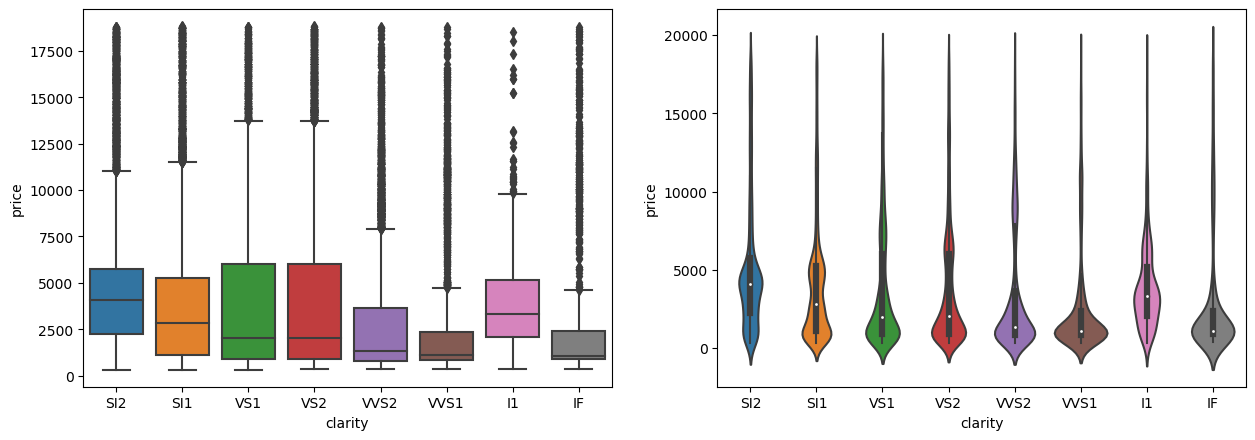

In [54]:
plt.figure(figsize=(15,5),dpi = 100)
plt.subplot(1,2,1)
sns.boxplot(x='clarity', y='price', data=tmp)
plt.subplot(1,2,2)
sns.violinplot(x='clarity', y='price', data=tmp)

Można zauważyć, że dla większości klas mediana ceny jest bardzo niska w porównaniu z trzecim kwartylem. Wyjątkami są **SI2** oraz **I1** czyli dwie najgorsze klasy czystości. <br>
Czystości **VVS2**, **VVS1** oraz **IF** mają bardziej zawężone przedziały cenowe od pozostałych klas.

### Color

Diamenty są wyceniane na podstawie tego, jak blisko zbliżają się do bezbarwności. Skala ma rozpiętość od D do Z. W naszym przypadku mamy jedynie diamenty bezbarwne D-F i prawie bezbarwne G-J. Poza podstawową skalą istnieją też tak zwane diamenty fantazyjne - takie jak różowe czy niebieskie, które znajdują się poza standardowym zakresem kolorów.

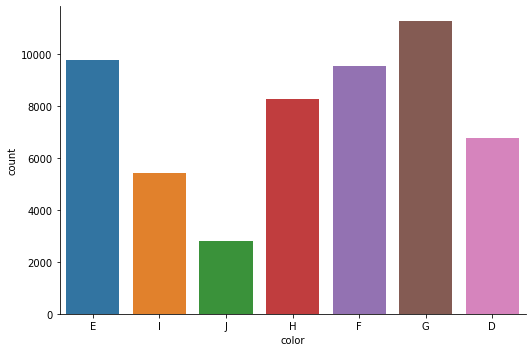

In [55]:
sns.catplot(x='color', data=tmp , kind='count',aspect=1.5 )

Najwięcej jest diamentów o kolorach średniej jakości.<br>
Diamentów o najlepszym kolorze **D** oraz najgorszych kolorach **I** i **J** jest mniejsza ilość.

#### color vs price

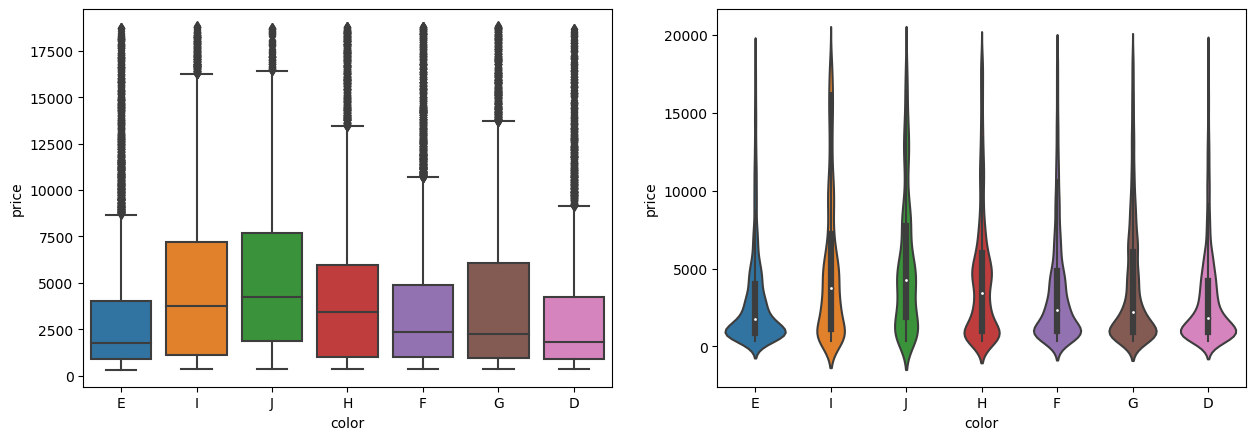

In [56]:
plt.figure(figsize=(15,5),dpi = 100)
plt.subplot(1,2,1)
sns.boxplot(x='color', y='price', data=tmp)
plt.subplot(1,2,2)
sns.violinplot(x='color', y='price', data=tmp)

Kolory **I**,**J** i **H** są bardziej rozrzucone niż pozostałe. Dla pozostałych kolorów mediana jest zbliżona do pierwszego kwartyla i są bardziej zagęszczone.

### Wnioski na temat danych kategorycznych

Artybuty **table** oraz **depth** są kluczowe dla naszej klasyfikacji. <br>
**Color** i **clarity** są nadmiarowe, ponieważ na ich podstawie nie jesteśmy w stanie okreścić jakości szlifu.<br>
W trakcie testowania klasyfikatorów okazało się, że atrybut **price** poprawia dokładność klasyfikatora o kilka procent, więc zachowujemy go.

In [57]:
dane = dane.drop(columns=['color','clarity'])
dane.head()

,cut,depth,table,price
0,Ideal,61.50,55.00,326
1,Premium,59.80,61.00,326
2,Good,56.90,65.00,327
3,Premium,62.40,58.00,334
4,Good,63.30,58.00,335


Do klasyfikacji wykorzystane są atrybuty **price** , **depth** oraz **table**.

# Klasyfikacja

### Podział danych

In [58]:
X = dane.iloc[:, 1:].values
y = dane.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 1.	Klasyfikator najbliższego sąsiada

### Znalezienie optymalnej liczby sąsiadów


Text(0, 0.5, 'Mean Error')

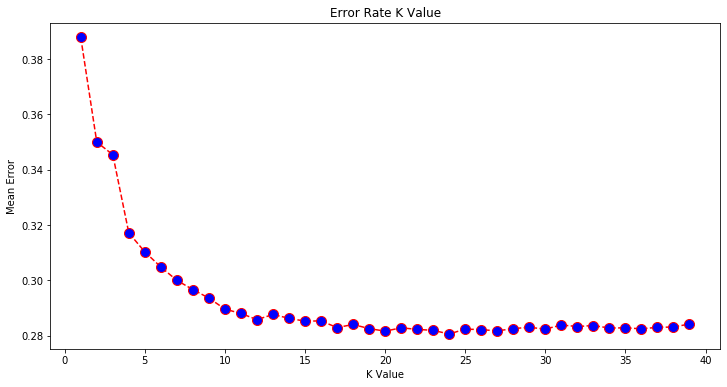

In [59]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Im więcej sąsiadów tym mniej błędów
Przetestujemy  wartości: 5, 16 oraz 29
Najmniejsza wartość występuje dla 30

### Klasyfikacja

### 5 sąsiadów

              precision    recall  f1-score   support

        Fair       0.86      0.83      0.84       328
        Good       0.65      0.60      0.62      1002
       Ideal       0.79      0.90      0.84      4275
     Premium       0.61      0.72      0.66      2709
   Very Good       0.51      0.32      0.39      2470

    accuracy                           0.69     10784
   macro avg       0.69      0.67      0.67     10784
weighted avg       0.67      0.69      0.67     10784

Wynik dokładności
0.6897255192878339


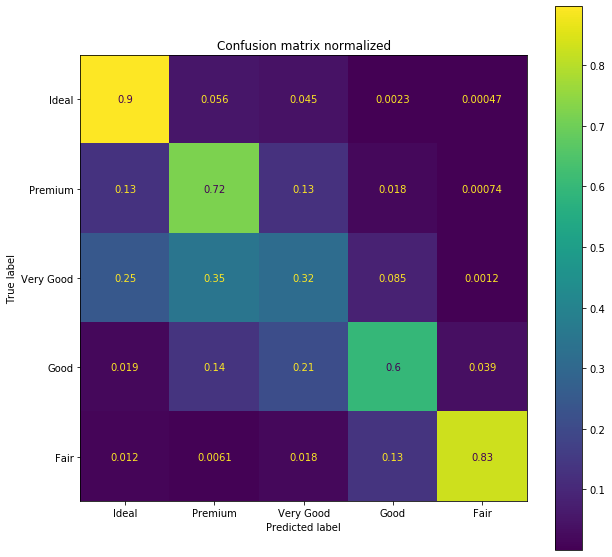

In [60]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### 16 sąsiadów

              precision    recall  f1-score   support

        Fair       0.88      0.81      0.84       328
        Good       0.71      0.58      0.63      1002
       Ideal       0.81      0.92      0.86      4275
     Premium       0.61      0.82      0.70      2709
   Very Good       0.59      0.28      0.38      2470

    accuracy                           0.71     10784
   macro avg       0.72      0.68      0.69     10784
weighted avg       0.70      0.71      0.69     10784

Wynik dokładności
0.714669881305638


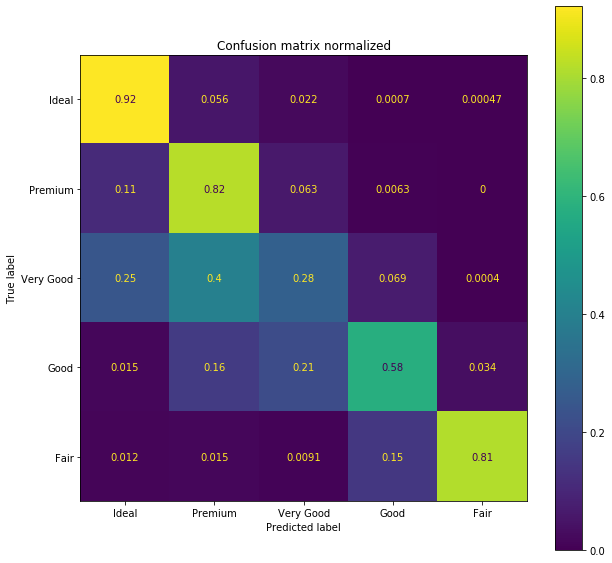

In [61]:
classifier = KNeighborsClassifier(n_neighbors=16)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### 30 sąsiadów

              precision    recall  f1-score   support

        Fair       0.90      0.78      0.84       328
        Good       0.72      0.57      0.63      1002
       Ideal       0.81      0.92      0.86      4275
     Premium       0.62      0.84      0.72      2709
   Very Good       0.61      0.28      0.39      2470

    accuracy                           0.72     10784
   macro avg       0.73      0.68      0.69     10784
weighted avg       0.71      0.72      0.69     10784

Wynik dokładności
0.7176372403560831


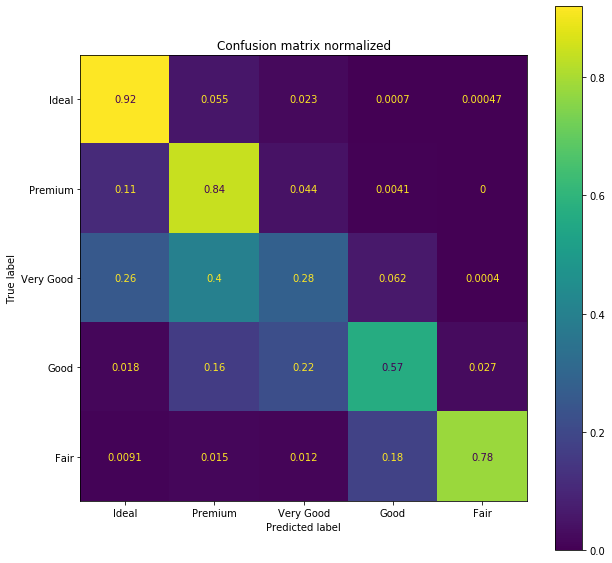

In [62]:
classifier = KNeighborsClassifier(n_neighbors=30)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### Wnioski

* Największą dokładność wykazuje model z 30 sąsiadami z dokładnością około 72%
* Wszystkie sprawdzone modele mają dokładność około 70%
* Najlepiej model klasyfikuje wartości skrajne (Ideal, Fair) oraz bardzo słabo rozpoznaje wartość środkową (Very Good)
* Miary precyzji i czułości są podobne
* Model błednie klasyfikuje wartość Very good jako Premium( około 40%), podobnie przy Good błednie klasyfikuje jako very good(20%) oraz premium (około 15 %)


# 2.   Naiwny klasyfikator Bayesa


              precision    recall  f1-score   support

        Fair       0.91      0.27      0.42       328
        Good       0.39      0.20      0.27      1002
       Ideal       0.72      0.92      0.80      4275
     Premium       0.58      0.74      0.65      2709
   Very Good       0.41      0.21      0.27      2470

    accuracy                           0.62     10784
   macro avg       0.60      0.47      0.48     10784
weighted avg       0.59      0.62      0.58     10784

Wynik dokładności
0.6227744807121661


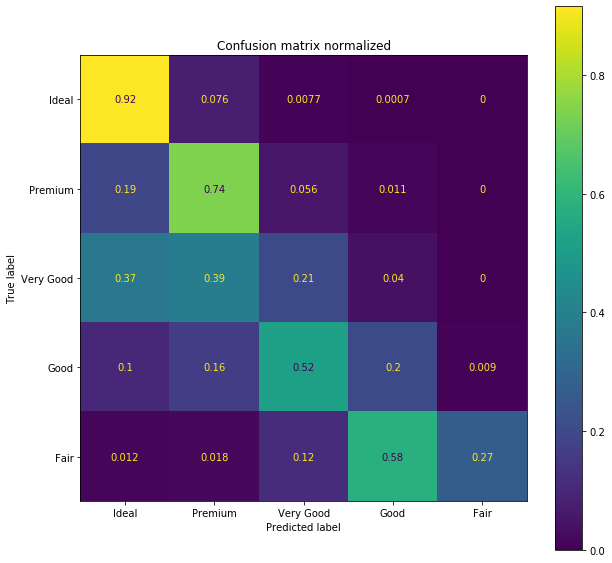

In [63]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### Wnioski

* Model wykazuje przecietną dokładność 65%
* Dobrze klasyfikuje wartości górne (Ideal, Premium) jednak z resztą słabo sobie radzi
* Mimo tego wartość Fair ma dużą precyzje co znaczy że jeśli model sklasyfikuje jako Fair prawdopodobnie będzie to dobra klasyfikacja

# 3.   Drzewo decyzyjne

### Znalezienie optymalnej głebokości

Text(0, 0.5, 'Mean Error')

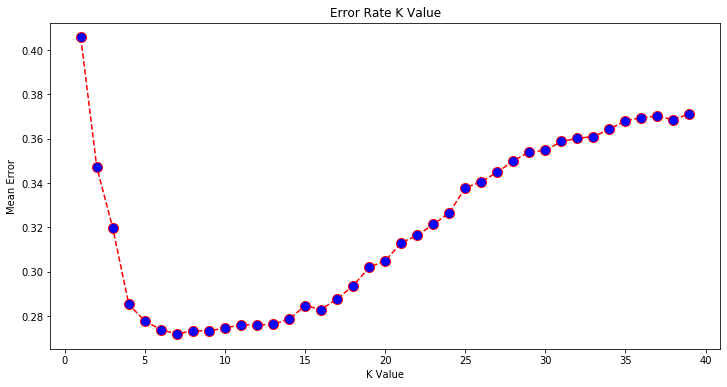

In [64]:
error = []

for i in range(1, 40):
    dTree = tree.DecisionTreeClassifier(max_depth=i)
    dTree.fit(X_train, y_train)
    pred_i = dTree.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Wykres spada do wartości 7 a następnie zaczyna rosnąć
Najmniejsza wartość to 7

### Klasyfikacja

### Głebokość 7

              precision    recall  f1-score   support

        Fair       0.88      0.90      0.89       328
        Good       0.81      0.60      0.69      1002
       Ideal       0.82      0.91      0.86      4275
     Premium       0.62      0.84      0.72      2709
   Very Good       0.61      0.33      0.43      2470

    accuracy                           0.73     10784
   macro avg       0.75      0.71      0.72     10784
weighted avg       0.72      0.73      0.71     10784

Wynik dokładności
0.7281157270029673


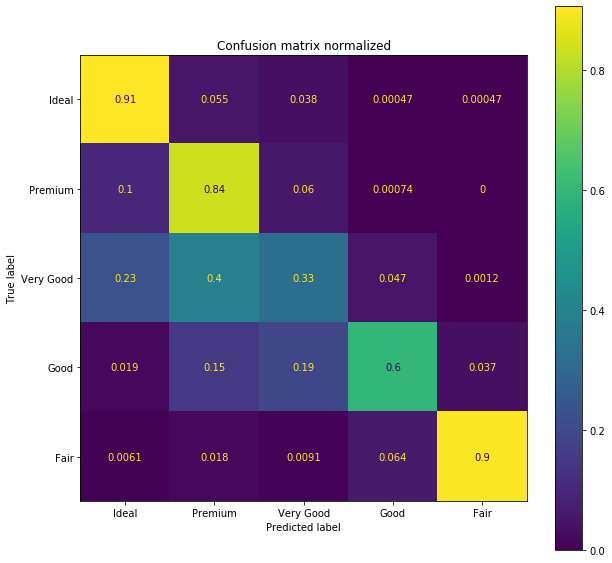

In [65]:
classifier = tree.DecisionTreeClassifier(max_depth=7)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### Głębokość 10

              precision    recall  f1-score   support

        Fair       0.86      0.88      0.87       328
        Good       0.80      0.55      0.66      1002
       Ideal       0.82      0.91      0.86      4275
     Premium       0.62      0.85      0.72      2709
   Very Good       0.60      0.32      0.42      2470

    accuracy                           0.73     10784
   macro avg       0.74      0.70      0.70     10784
weighted avg       0.72      0.73      0.71     10784

Wynik dokładności
0.7250556379821959


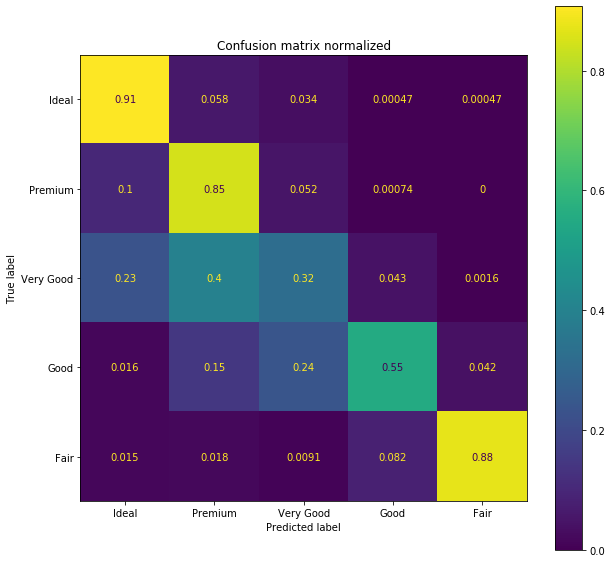

In [66]:
classifier = tree.DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### Wnioski

* Model klasyfikuje z dokładnoscią prawie 73% dla głebokości 7
* Najlepiej model klasyfikuje wartości skrajne (Ideal, Fair) oraz bardzo słabo rozpoznaje wartość środkową (Very Good)
* Miary precyzji i czułości są podobne jednak bardzo małą czułoscią charakteryzuje się wartość Very Good w porównaniu do jej precyzji
* Model błednie klasyfikuje wartość Very good jako Premium( około 40%), podobnie przy Good błednie klasyfikuje jako very good(20%) oraz premium (około 15 %)

# 4. Metoda najbliższych prototypów

              precision    recall  f1-score   support

        Fair       0.28      0.72      0.40       328
        Good       0.09      0.14      0.11      1002
       Ideal       0.76      0.81      0.78      4275
     Premium       0.50      0.52      0.51      2709
   Very Good       0.21      0.09      0.12      2470

    accuracy                           0.51     10784
   macro avg       0.37      0.46      0.39     10784
weighted avg       0.49      0.51      0.49     10784

Wynik dokładności
0.5079747774480712


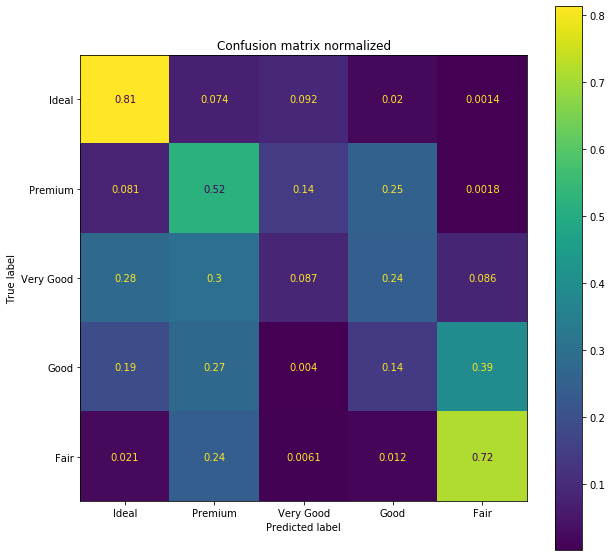

In [67]:
classifier = NearestCentroid()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))



fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

### Wnioski

* Model ma slabą dokładność równą około 51%

# Wynik


* Modele Metoda najbliższych prototypów oraz    Naiwny klasyfikator Bayesa mają słabą dokładność i nie są odpowiednie do klasyfikacji
* Klasyfikator najbliższego sąsiada wykazuje najlepszą dokładność dla 30 sąsiadów równą 72% i ma bardzo zbliżone metryki do drzewa decyzjnego
* Drzewo decyzyjne mimo dużego podobieństwa do KNN jest dokładniejsze dla głebokości 7 z dokładnością 73,4%


# Najlepszy klasyfikator: Drzewo decyzyjne z głebokością 7

              precision    recall  f1-score   support

        Fair       0.88      0.90      0.89       328
        Good       0.81      0.60      0.69      1002
       Ideal       0.82      0.91      0.86      4275
     Premium       0.62      0.84      0.72      2709
   Very Good       0.61      0.33      0.43      2470

    accuracy                           0.73     10784
   macro avg       0.75      0.71      0.72     10784
weighted avg       0.72      0.73      0.71     10784

Wynik dokładności
0.7281157270029673


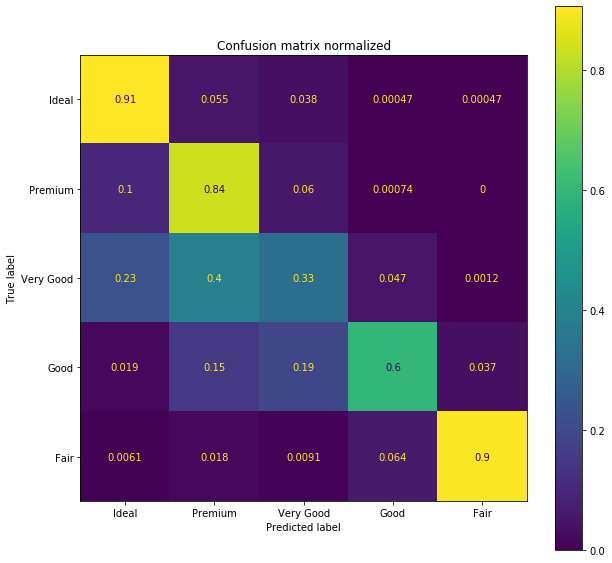

In [68]:
classifier = tree.DecisionTreeClassifier(max_depth=7)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


print(classification_report(y_test, y_pred))



print('Wynik dokładności')
print(accuracy_score(y_test,y_pred))


fig, ax = plt.subplots(figsize=(10, 10))
disp=plot_confusion_matrix(classifier,X_test, y_test,normalize    = 'true' ,ax=ax,labels=['Ideal',"Premium",'Very Good','Good','Fair'])
disp.ax_.set_title("Confusion matrix normalized")
print(disp)

* Najlepiej rozpoznaje cięcie Ideal oraz Fair ze wszystkimi metrykami około 90% 
* Cięcie premium jest dobrze rozpoznawane jednak mogą znajdować się w nim błędy
* Ciecie Very good jest słabo klasyfikowane mimo największej pomocy
* Model jest skuteczny w okolo 73%, a więc nie jest idelany, co oznacza że nie udało nam się znaleść idealnego klasyfikatora ( średnio klasyfikuje atrybut Good, a Very Good bardzo słabo i błędnie przypisuje je jako premium albo very good)